### Lecture 1, step 2: Using Essentia-standard for computing the features

In this version, we demonstrate use of Essentia for some basic operations file reading, framing/windowing,spectrum estimation, etc. 

Be aware that this code does not represent a best practice of computing features with Essentia. In most cases you would prefer using Essentia-streaming mode for speed and code simplicity.

This notebook replicates that of Lecture 1 - step 1 using Essentia. This notebook does not have student version.

In [1]:
import os
import sys
import pickle
import numpy as np
import essentia.standard as ess
import matplotlib.pyplot as plt

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import IPython.display as ipd

#Container for analysis parameters
class AnalysisParams:
    def __init__(self,windowSize,hopSize,windowFunction,fftN,fs):
        '''
        windowSize: milliseconds,
        hopSize: milliseconds,
        windowFunction: str ('blackman','hanning',...)
        fftN: int
        '''
        self.windowSize = windowSize
        self.hopSize = hopSize
        self.windowFunction = windowFunction
        self.fftN=fftN
        self.fs=fs

def initiate_data_for_file(file, root):
    '''Forming the data structure for file
    Parameters
    ----------
    file,root : str
        File name and path info
    
    Returns
    -------
    fileData : dict
        Dictionary containing all info and data for the file
    ''' 
    fileData = dict(); fileData['name'] = file; fileData['path'] = root;
    #Low level(LL) features
    fileData['NRG'] = []; fileData['zcr'] = [];#time domain features
    fileData['specCentroid'] = []; fileData['specFlatness'] = [];#frequency domain features
    
    return fileData

def compute_low_level_features(fileData,params):
    '''Computation of the low-level features
    Parameters
    ----------
    fileData : dict
        Dictionary containing all info and data for the file
    params : instance of AnalysisParams
        Analysis parameters
    Modifies
    -------
    fileData 
    '''
    #Reading the wave file
    fs = params.fs
    x = ess.MonoLoader(filename = os.path.join(fileData['path'], fileData['name']), sampleRate = fs)()

    #Windowing (first converting from msec to number of samples)
    windowSize = round(fs * params.windowSize / 1000);
    windowSize = int(windowSize / 2) * 2#assuring window size is even
    hopSize = round(fs * params.hopSize / 1000);
    hopSize = int(hopSize / 2) * 2#assuring hopSize is even

    #Initializing lists for features
    NRG = []; zcr = []; specCentroid = []; specFlatness = []
    #Main windowing and feature extraction loop
    for frame in ess.FrameGenerator(x, frameSize = windowSize, hopSize = hopSize, startFromZero=True):
        frame=ess.Windowing(size = windowSize, type = params.windowFunction)(frame)
        NRG.append(ess.Energy()(frame))
        zcr.append(ess.ZeroCrossingRate()(frame))
        specCentroid.append(ess.SpectralCentroidTime()(frame))#spectral centroid computation from time-domain signal 
        specFlatness.append(ess.Flatness()(ess.Spectrum(size = params.fftN)(frame)))

    #Scaling features for simplicity of plotting together
    specFlatness = specFlatness / (np.max(np.abs(specFlatness)))
    NRG = NRG / (np.max(np.abs(NRG)))
    zcr = zcr / (np.max(np.abs(zcr)))
    specCentroid = specCentroid/(np.max(np.abs(specCentroid)))
    
    fileData['NRG'] = np.array(NRG);
    fileData['zcr'] = np.array(zcr);
    fileData['specCentroid'] = np.array(specCentroid);
    fileData['specFlatness'] = np.array(specFlatness);

def compute_global_features(fileData, NRGthreshold = 0.05):
    '''Computation of the global features from low-level features
    An energy threshold (NRGthres*maxEnergy) is applied to exclude features from silence regions

    Parameters
    ----------
    fileData : dict
        Dictionary containing all info and data for the file
    NRGthresPerc: float
        Energy threshold defined as ratio to maximum energy. Ex: 0.05 corresponds to 5%
    Modifies
    -------
    fileData 
    '''
    #To remove from feature data those coming from silence regions, let's use an energy threshold (%5 of the max) 
    NRG = fileData['NRG']
    keepIndexes = NRG > (np.max(NRG) * NRGthreshold)
    
    features = list(fileData.keys())
    features.remove('path');features.remove('name')
    for feature in features:
        data = np.array(fileData[feature][keepIndexes])
        fileData['std_' + feature] = np.std(data)
        fileData['mean_' + feature] = np.mean(data)

**Running feature extraction, saving to file and reading from file**

In [2]:
#Setting analysis parameters
# windowSize: milliseconds,hopSize: milliseconds,windowFunction: str ('blackman','hanning',...),fftN: int
params = AnalysisParams(30, 10, 'hann', 2048, 44100)
soundsDir = '../data/freesound/'

#Collecting wave file names in a folder(and its subfolders)
classFiles = dict()
for root, dirs, files in os.walk(soundsDir):
    for file in files:
        if file.endswith('.wav'):
            soundClass = file.split('_')[0]
            if(str.isalpha(soundClass)):
                fileData = initiate_data_for_file(file, root)            
                files4soundClass = classFiles.get(soundClass)
                if files4soundClass == None:
                    files4soundClass = [fileData]
                else:
                    files4soundClass.append(fileData)
                classFiles[soundClass] = files4soundClass

#Feature extraction for all files of each soundClass
for soundClass, filesData in classFiles.items():
    for fileInd in range(len(filesData)):
        compute_low_level_features(classFiles[soundClass][fileInd], params)
        compute_global_features(classFiles[soundClass][fileInd])


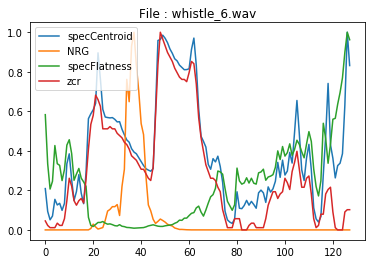

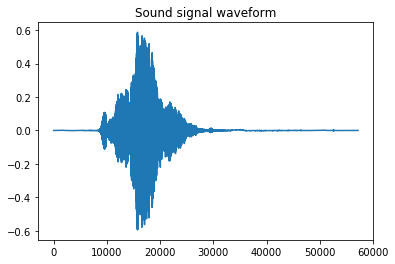

In [3]:
#Let's print an example
fileInd = 0; soundClass = 'whistle';
plt.title('File : ' + classFiles[soundClass][fileInd]['name'])
plt.plot(classFiles[soundClass][fileInd]['specCentroid'], label = 'specCentroid')
plt.plot(classFiles[soundClass][fileInd]['NRG'],label = 'NRG')
plt.plot(classFiles[soundClass][fileInd]['specFlatness'],label = 'specFlatness')
plt.plot(classFiles[soundClass][fileInd]['zcr'],label = 'zcr')
plt.legend(loc = 'best')
plt.show()
x = ess.MonoLoader(filename = os.path.join(classFiles[soundClass][fileInd]['path'], classFiles[soundClass][fileInd]['name']), sampleRate = 44100)()
plt.plot(x)
plt.title('Sound signal waveform')
plt.show()
#ipd.Audio(x, rate=params.fs)